# Kaskawulsh: MCMC Test

Our overall goal find a consitent set of mass balance parameters which are regionally characersitc of the Yukon. We started by running uncoupled `Elmer/Ice` simulations using [Young et al. 2021](https://www-cambridge-org.proxy.lib.sfu.ca/core/journals/journal-of-glaciology/article/an-imbalancing-act-the-delayed-dynamic-response-of-the-kaskawulsh-glacier-to-sustained-mass-loss/350065B3C0CD9A900DCBA7D60445D583) results for the surface mass balance forcing. Each glacier need a scalar offset ranging from XX-XX $\rm{m i.e. a^{-1}}$ for the steady-state configuration to have a similar volume as it's observed volume. Now we seek to inver for the appropriate mass balance parameter in our simplified model to match the (`Elmer/Ice`) modeled net balance cruve. 

But, it appears we have "jumped the gun" a little. We have yet to confirm whether our simple model, following Gilbert et al. 2016 is able to recreate the reults from Young et al. 2021. It's very possible we may need to introduce additional paramater, like a precipitation bias correction, for our model to match the Young et al. 2021 results. This is what we explore below! 


Collection of links / rescources: 

- [Paper about non-centered distribution](https://arxiv.org/pdf/1312.0906.pdf)

- [Young et al. 2020 Supplementary Material](https://static.cambridge.org/content/id/urn:cambridge.org:id:article:S0022143020001070/resource/name/S0022143020001070sup001.pdf)

- [Rounce et al. 2020](https://www-cambridge-org.proxy.lib.sfu.ca/core/services/aop-cambridge-core/content/view/61D8956E9A6C27CC1A5AEBFCDADC0432/S0022143019000911a.pdf/quantifying_parameter_uncertainty_in_a_largescale_glacier_evolution_model_using_bayesian_inference_application_to_high_mountain_asia.pdf)

- [Rounce et al. 2020 Supplementary Material](https://static.cambridge.org/content/id/urn:cambridge.org:id:article:S0022143019000911/resource/name/S0022143019000911sup001.pdf)

- [Huss and Hock, 2015](https://www.readcube.com/articles/10.3389/feart.2015.00054)

- [Huss and Hock, 2015 Supplementary Material](file:///Users/andrewnolan/Downloads/supplementary%20material.pdf)

In [1]:
import PDD
import numpy as np
import pymc3 as pm 
import arviz as az
import xarray as xr
from numpy import random
from scipy import interpolate
import matplotlib.pyplot as plt 

plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})

__Load the NetCDF with Kaskawulsh Data__: 

In [2]:
nc_fp = "../MB_tune/Young_etal_2020_ref_MB.nc"

with xr.open_dataset(nc_fp) as MB_ref: 
    z_nc = MB_ref.mean('ref_run').stack(z=('x', 'y')).Elevation.values
    
z = np.linspace(np.nanmin(z_nc), np.nanmax(z_nc), 1000)

I think I forgot account for precipitation in the form of rain, lets take a look at Katies data: 

In [3]:
nc_fp = "../MB_tune/notebooks/Young_etal_2020_Delta_T_-0.9_C.nc"

with xr.open_dataset(nc_fp) as MB_new: 
    pass

Old_A_mean =  MB_new.stack(z=('x', 'y')).Accumulation.mean().values
New_A_mean = (MB_new.stack(z=('x', 'y')).Accumulation + \
              MB_new.stack(z=('x', 'y')).Rain.values).mean().values
Temp_mean  =  MB_new.stack(z=('x', 'y')).temp.mean().values

print('A_mean (snow)        = {:+.2f}'.format(Old_A_mean))
print('A_mean (snow + rain) = {:+.2f}'.format(New_A_mean))
print('T_mean               = {:+.2f}'.format(Temp_mean))


A_mean = New_A_mean

A_mean (snow)        = +1.41
A_mean (snow + rain) = +1.53
T_mean               = -8.67


__Load the spline related data__:

In [4]:
# file paths to knots and coefs 
coefs_fp = '../../input_data/mass_balance/cubic_spline_coefs_s_1500_weighted.dat'
knots_fp = '../../input_data/mass_balance/cubic_spline_knots_s_1500_weighted.dat'

# load the knots and coefs into memory
coefs = np.loadtxt(coefs_fp)
knots = np.loadtxt(knots_fp)

# make the tck tuple used by splev 
tck = (knots, coefs, 3)

__Prediction with Spline__:

In [5]:
# Do the prediction 
mb     = interpolate.splev(z,tck)
# Add some random noise 
mb_obs = random.normal(mb, 0.35)

__Visualize Mass balance Data__: 

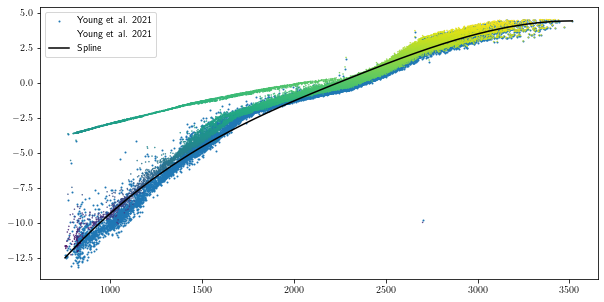

In [6]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(MB_ref.Elevation, 
           MB_ref.MB.mean('ref_run'),
           s=1,
           label='Young et al. 2021')

ax.scatter(MB_new.Elevation, 
           MB_new.MB,
           c= MB_new.MB,
           s=0.25,
           label='Young et al. 2021')

# ax.scatter(z, mb_obs, s=1, 
#            label = "Spline with noise")

ax.plot(z, mb, c='k', label = "Spline")

ax.legend()

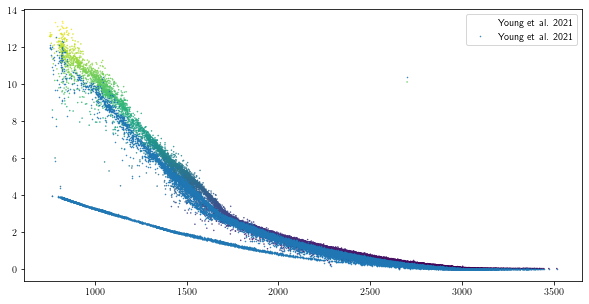

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

ax.scatter(MB_ref.Elevation, 
           MB_ref.Melt.mean('ref_run'),
           c= MB_ref.Melt.mean('ref_run'),
           s=0.25,
           label='Young et al. 2021')

ax.scatter(MB_new.Elevation, 
           MB_new.Melt,
           c= "tab:blue",
           s=0.25,
           label='Young et al. 2021')
ax.legend()

In [8]:
stacked = MB_ref.stack(z=('x','y'))

# Calculate the Kaskawulsh ELA 
ELA_idxs = np.argpartition(np.abs(stacked.mean('ref_run').MB.values), 5)
z_ELA    = float(stacked.isel(z=ELA_idxs[:5]).Elevation.mean())

idxs  = stacked.dropna('z').z.values
elev  = stacked.Elevation.dropna('z').values
idxs  = idxs[np.argsort(elev)]
Accum = stacked.mean('ref_run').sel(z=idxs)

In [9]:
z_ELA

2359.0657714840004

__Initialize our Mass Balance Model__:

These are the reference model parameters. They may need to be changed later

In [10]:
import theano
import warnings
warnings.filterwarnings(action='ignore')
theano.config.compute_test_value = 'warn'

# dictionary of PDD model parameters
const =  dict(T_m    = 0.0, 
              T_rs   = 1.0,
              A_mean = A_mean * 910., 
              α      = 10.5, 
              T_ma   = Temp_mean,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196,
#               T_σ    = 1.5*fancy_std[:,np.newaxis],
              T_σ    = 8.6,
              ref_z  = 2193)

# initialize the PDD melt model class
PDD_LA = PDD.PDD_LA(**const)

__Paramter Inversion with the MCMC Model__: 

In [11]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_prior  = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=1.5,  lower=0.0)
    # Somewhat base of Aschwanden et al. 2019
    C_prior    = pm.TruncatedNormal("C",      mu=2.0,  sigma=0.75,  lower=1)
    # Need a reference for the accumulation grad distibution 
    grad_a     = pm.Uniform("grad_a", lower=0.5e-4, upper=5e-4)
    # Somewhat base of Aschwanden et al. 2019
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.2,  lower=0.0, upper=1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    melt = PDD_LA.tt_forward(z, f_s_prior, C_prior, f_r_prior, grad_a)
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=melt, sigma=sigma, observed=mb_obs)
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
#     startvals = pm.find_MAP() 
    
    trace = pm.sample(#start=startvals,
                      draws=2000, 
                      tune=2000, 
                      cores=2, 
                      return_inferencedata=True, 
                      target_accept=0.99);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, f_r, grad_a, C, f_s]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 150 seconds.
The number of effective samples is smaller than 25% for some parameters.


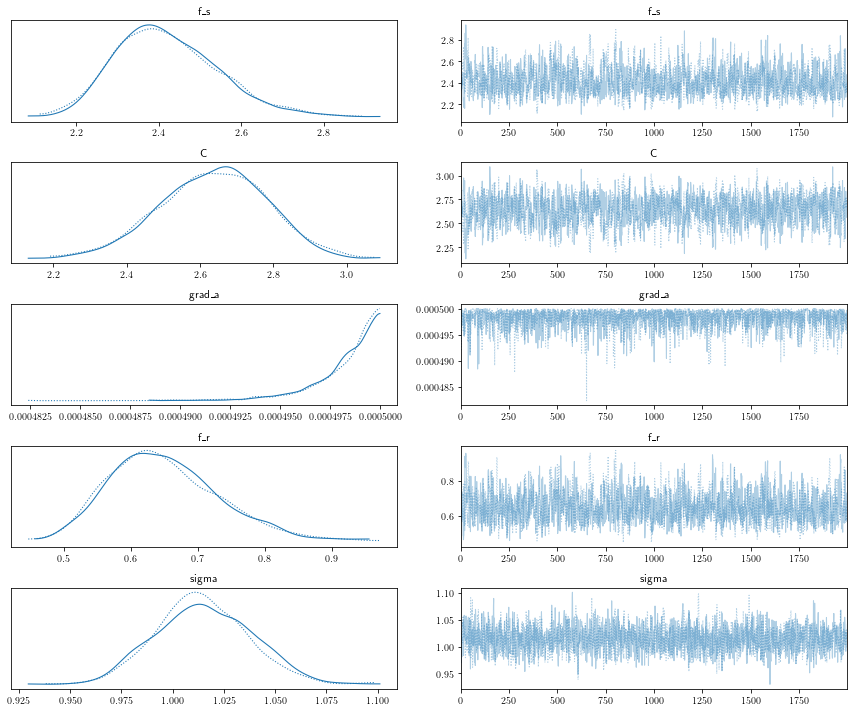

In [12]:
az.plot_trace(trace );
plt.tight_layout()

In [13]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "f_r", "grad_a", "sigma"])

In [14]:
def plot_parts(model, z, params, ax, i ): 
    MB, A, R, M, f_m, r_s2m = model.eval_forward(z, *params)
    
            
    ELA_idx = np.argpartition(np.abs(MB), 2)[:2]
    ELA = np.mean(z[ELA_idx])
    
    if i == 0: 
        ax.plot(z, A , alpha=1.0, c='#377eb8', label='Accumulation')
        ax.plot(z, R , alpha=1.0, c='#4daf4a', label='Refreezing')
        ax.plot(z, M , alpha=1.0, c='#984ea3', label='Melt')
        ax.plot(z, MB, alpha=1.0, c='#e41a1c', label='Mass Balance')
        
        ax.axvline(ELA, c='grey', lw=0.5, alpha=1.0, label='Modeled ELA')
        
    else:
        ax.plot(z, A , alpha=0.1, c='#377eb8')
        ax.plot(z, R , alpha=0.1, c='#4daf4a')
        ax.plot(z, M , alpha=0.1, c='#984ea3')
        ax.plot(z, MB, alpha=0.1, c='#e41a1c')
        
        ax.axvline(ELA, c='grey', lw=0.5, alpha=0.1)
        

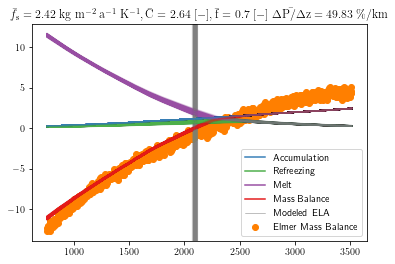

In [15]:
fig, ax = plt.subplots()

for i, j in enumerate(np.random.randint(0,3999,499)):
    params = []

    for key in list(ppc)[:-1]: 
        if len(ppc[key].shape) == 2: 
            params.append(ppc[key][j])
        else: 
            params.append(ppc[key][j])

    plot_parts(PDD_LA, z, params, ax, i)
    
ax.scatter(z, mb_obs, c='#ff7f00', label='Elmer Mass Balance')
ax.legend()

param_means = [np.mean(ppc[key])*1000*100 if key == 'grad_a' else np.mean(ppc[key]) for key in list(ppc)[:-1]]

params_string = r"$\bar{{f}}_{{\rm s}}         = {:.2f} \rm{{\;kg \;m^{{-2}} \; a^{{-1}} \;" +\
                r"K^{{-1}}}}, \bar{{C}}        = {:.2f} \;[-],"+\
                r"\bar{{f}}_{{\rm }}           = {:.1f} \;[-]" +\
                r"\; \bar{{\Delta P/\Delta z}} = {:.2f} \; \%/\rm{{km}}$"

ax.set_title(params_string.format(*param_means));
             
# fig.savefig(f'Kaskawulsh_T_ma={T_ma}_A_mean={A_mean}_no_enhancement.pdf', bbox_inches='tight', facecolor='w')
# fig.savefig('/Users/andrewnolan/Desktop/fancystd_w_priors_from_references.png', dpi=300, bbox_inches='tight', facecolor='w')

In [16]:
MB_LA, A_LA, R_LA, M_LA, f_m_LA, r_s2m_LA = PDD_LA.eval_forward(z, *params)

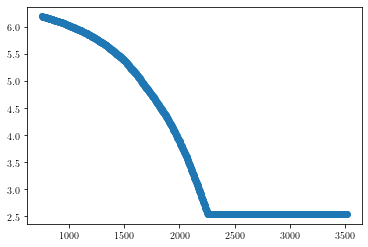

In [17]:
plt.scatter(z, f_m_LA)

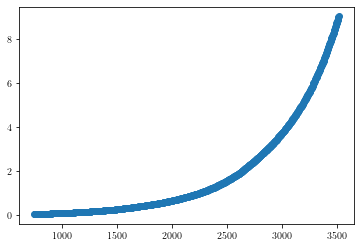

In [18]:
plt.scatter(z, r_s2m_LA)

__PDD Model w/ Piecewise Accumulation__: 

In [19]:
import theano
import warnings
warnings.filterwarnings(action='ignore')
theano.config.compute_test_value = 'warn'


# dictionary of PDD model parameters
const =  dict(T_m    = 0.0, 
              T_rs   = 1.0,
              α      = 10.5, 
              T_ma   = Temp_mean,
              ΔTΔz   = 6.5E-3, 
              T_p    = 196, 
              ref_z  = 2193,
              T_σ    = 2*8.6,
              z_ELA  = z_ELA)

# initalize the PDD melt model class
PDD_PWA = PDD.PDD_PWA(**const)

In [20]:
# Define Priors
with pm.Model() as model: 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Mass balance Model (physical priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Degree Day factor: Braithwaite (2008) / Rounce et al. 2020
    f_s_prior  = pm.TruncatedNormal("f_s",    mu=4.1,  sigma=1.5,  lower=0.0)
    # Somewhat base of Aschwanden et al. 2019
    C_prior    = pm.TruncatedNormal("C",      mu=2.0,  sigma=0.75,  lower=1, upper=3.0)
    # Somewhat base of Aschwanden et al. 2019
    f_r_prior  = pm.TruncatedNormal('f_r',    mu=0.5,  sigma=0.2,  lower=0.0, upper=1)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----> Hyperparameters (likelihood related priors)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    sigma      = pm.HalfCauchy("sigma", 10)    


# Define Forward model (wrapped through theano)
with model: 
    melt = PDD_PWA.tt_forward(z, f_s_prior, C_prior, f_r_prior)
    

# Define likelihood (function?)  
with model: 
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=melt, sigma=sigma, observed=mb_obs)
    
# run inference: Sample   
with model: 

    # obtain starting values via MAP
#     startvals = pm.find_MAP() 
    
    trace = pm.sample(#start=startvals,
                      draws=2000, 
                      tune=2000, 
                      cores=2, 
                      return_inferencedata=True, 
                      target_accept=0.99);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, f_r, C, f_s]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


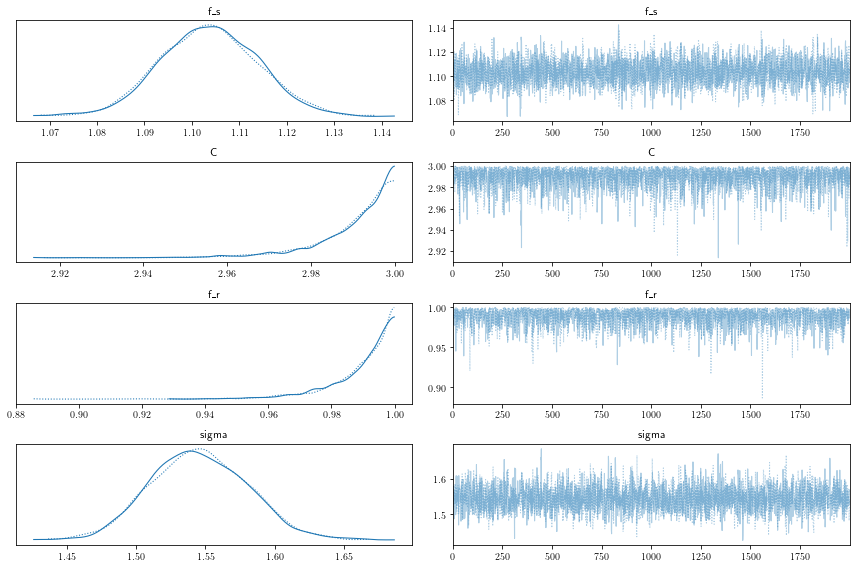

In [21]:
az.plot_trace(trace );
plt.tight_layout()

In [22]:
with model: 
    ppc = pm.sample_posterior_predictive(
    trace, var_names=["f_s", "C", "f_r", "sigma"])

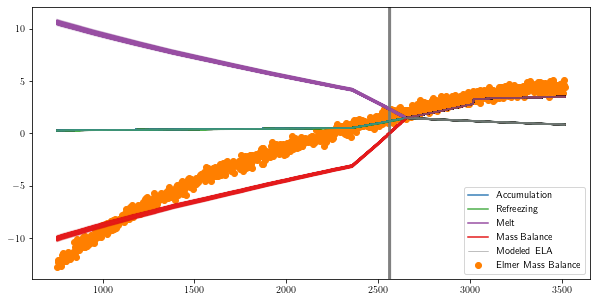

In [23]:
fig, ax = plt.subplots(figsize=(10,5))

for i, j in enumerate(np.random.randint(0,3999,499)):
    params = []

    for key in list(ppc)[:-1]: 
        if len(ppc[key].shape) == 2: 
            params.append(ppc[key][j])
        else: 
            params.append(ppc[key][j])

    plot_parts(PDD_PWA, z, params, ax, i)
    
ax.scatter(z, mb_obs, c='#ff7f00', label='Elmer Mass Balance')
ax.legend()

# ax.set_title("$\\bar{{T}}={} ^\\circ C, \;\; \\bar{{P}}={} \; \\rm{{m i.e. y}}^{{-1}}$, $k_p$={:.2f} + $\\sigma=$1.5".format(T_ma, A_mean, ppc['P_bias'].mean()))
fig.savefig("/Users/andrewnolan/Desktop/test.png", dpi=300, bbox_inches='tight', facecolor='w')


In [24]:
MB_PWA, A_PWA, R_PWA, M_PWA, f_m_PWA, r_s2m_PWA = PDD_PWA.eval_forward(z, *params)
MB_PWA_2, A_PWA_2, R_PWA_2, M_PWA_2, f_m_PWA_2, r_s2m_PWA_2 = PDD_PWA.eval_forward(z, 2.5, 1.5, 0.7)

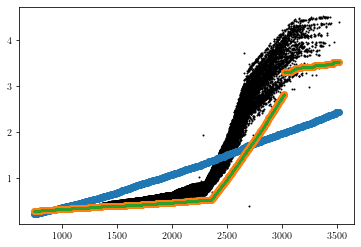

In [25]:
plt.scatter(MB_new.Elevation, MB_new.Accumulation, s=1.0, c='k')
plt.scatter(z, A_LA,    c='tab:blue')
plt.scatter(z, A_PWA,   c='tab:orange')
plt.scatter(z, A_PWA_2, c='tab:green', marker='x', s=2.0)

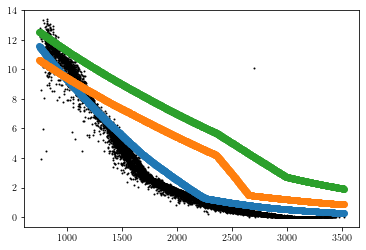

In [26]:
plt.scatter(MB_ref.Elevation, MB_ref.mean('ref_run').Melt, s=1.0, c='k')
plt.scatter(z, M_LA, c='tab:blue')
plt.scatter(z, M_PWA, c='tab:orange')
plt.scatter(z, M_PWA_2, c='tab:green')

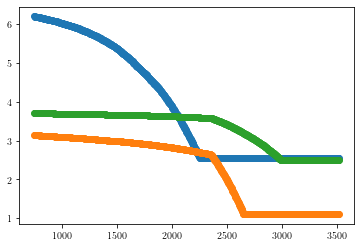

In [27]:
plt.scatter(z, f_m_LA)
plt.scatter(z, f_m_PWA)
plt.scatter(z, f_m_PWA_2)

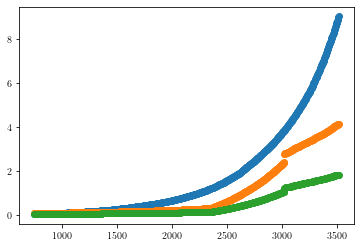

In [28]:
plt.scatter(z, r_s2m_LA)
plt.scatter(z, r_s2m_PWA)
plt.scatter(z, r_s2m_PWA_2)

In [29]:
r_s2m_LA

array([0.04695485, 0.04727999, 0.04785831, 0.04818779, 0.0485186 ,
       0.04885074, 0.04918422, 0.04951905, 0.04985523, 0.05045691,
       0.05079694, 0.05140566, 0.05174982, 0.05209537, 0.05271466,
       0.05306367, 0.05369084, 0.0540445 , 0.05439958, 0.05503836,
       0.05539818, 0.05604541, 0.05640961, 0.05706476, 0.05743359,
       0.05780394, 0.05847111, 0.05914359, 0.05952232, 0.05990224,
       0.06028341, 0.06066596, 0.06135567, 0.06174209, 0.06244075,
       0.0631449 , 0.06354001, 0.06393674, 0.06433512, 0.06473514,
       0.06513682, 0.06554016, 0.06627094, 0.06700735, 0.06774874,
       0.06816334, 0.06857966, 0.06899771, 0.06941631, 0.0698362 ,
       0.07025783, 0.07068121, 0.07110635, 0.07153325, 0.07196193,
       0.07239241, 0.07282469, 0.07325878, 0.07369389, 0.07413075,
       0.07456944, 0.07500998, 0.07545237, 0.07589664, 0.07634278,
       0.07679023, 0.0772391 , 0.07768906, 0.07814091, 0.07859455,
       0.07904927, 0.07989374, 0.08035414, 0.0808159 , 0.08127